## Open Points/ to-dos / Notes
- When identifying Italians and Germans, we need to look at the same repositories in both time periods. Next step after finishing Italian Identification
- For the Metrics: normalize values  to the range of 0% (lowest) and 100% (highest) and add more metrics than simple counts of fork and push/pull
- Before scaling to longer timeframes, scale from hourly to daily datapoints?

instead of counting forks, count the nubmer unique actors per repository for each time stamp and add an new column of a new metric 

papers to remember
- Hasabnis, N. (2022). GitRank: A Framework to Rank GitHub Repositories. Proceedings - 2022 Mining Software Repositories Conference, MSR 2022, 729–731. https://doi.org/10.1145/3524842.3528519 


# Dependent Variable: Collaboration

#### Has the introduction of ChatGPT increased collaboration among Software Developers?
1. Contribution >> Count Forks
2. Commit Frequency >> Count push/pull Events
3. Commit diversity >> count unique contributers per repository

# First Takeaways - Data Distribution

#### Concentration of Activity, Skewed Distribution, Disparate Engagement
- Significant centralization within a few repositories, coupled with a high degree of data asymmetry, highlighting both selectivity in community engagement and a disproportionate focus on a minimal number of projects. 
- Predominance of repositories with minimal activity, indicating that numerous projects may be personal, experimental, or in early stages of development.

#### Implications
- Applying stratified sampling techniques, such as categorizing repositories into high/medium/low-activity segments, alongside employing specialized statistical methodologies tailored for skewed distributions. 
- Prioritizing data filtering and robust analytical techniques to differentiate dormant or less popular projects from those with genuine user engagement, ensuring the research focuses on meaningful activity without being overwhelmed by the volume of low-activity data.

In [1]:
# Standard library imports
import os
import sys
import gzip
import json
import time
from datetime import datetime, timedelta
import ast
import warnings

# Third-party imports
import pandas as pd
import numpy as np
import requests
import seaborn as sns
import matplotlib.pyplot as plt
from joblib import dump, load
import statsmodels.api as sm
import statsmodels.formula.api as smf

# Local application imports
from config import config

# Suppress all future warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

# Import IT and DE data

- DE/IT : login and location of Users from DE and IT
- python_repositories_all: raw archive data filtered for only python repos

In [2]:
python = pd.read_csv('data/python_repositories_all.csv')
IT_user = pd.read_csv('data/pandas_IT_df.csv')
DE_user = pd.read_csv('data/pandas_DE_df.csv')

In [3]:
def convert_row_to_dict(row_str):
    try:
        # Remove "Row(" from the start and ")" from the end
        trimmed = row_str[4:-1]

        # Split the content using ', ' which gives key=value pairs
        kv_pairs = trimmed.split(", ")

        # Process each key=value pair
        result_dict = {}
        for kv in kv_pairs:
            key, value = kv.split("=")

            # Remove the quotes around the value. 
            if value.startswith("'") and value.endswith("'"):
                value = value[1:-1]
            
            # Handle special case where value is None without quotes
            if value == "None":
                value = None

            result_dict[key] = value

        return result_dict
    except Exception as e:
        print(f"Failed to parse row: {row_str}, error: {e}")
        return None

# Apply this function to each element of the 'actor' column and replace it in place
python['actor'] = python['actor'].apply(convert_row_to_dict)

# Do the same for the 'repo' column and the payload 'payload' column
python['repo'] = python['repo'].apply(convert_row_to_dict)

In [4]:
# directly extracting the 'login' information from the 'actor' column.
python['actor_login'] = python['actor'].apply(lambda x: x.get('login') if isinstance(x, dict) else None)

# Filter 'python' DataFrame to only have rows where 'actor_login' is in DE's or IT's login'
DE_filtered = python[python['actor_login'].isin(DE_user['login'])]
IT_filtered = python[python['actor_login'].isin(IT_user['login'])]

# Add a 'Treatment' column to each DataFrame, with value = 1 for DE and 0 for IT
DE_filtered['Treatment'] = 1
IT_filtered['Treatment'] = 0

# Concatenate the two DataFrames. This can be done because they have the same columns.
DE_IT_commits = pd.concat([DE_filtered, IT_filtered])

# Save the combined DataFrame to a CSV
DE_IT_commits.to_csv('data/DE_IT_commits_test.csv', index=False)

/tmp/ipykernel_4279/2778107117.py:9: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  DE_filtered['Treatment'] = 1
/tmp/ipykernel_4279/2778107117.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  IT_filtered['Treatment'] = 0


In [5]:
DE_IT_commits.head()

,actor,created_at,id,org,payload,public,repo,type,repo_name,user,language,full_repo_name,actor_login,Treatment
817,{'avatar_url': 'https://avatars.githubusercont...,2023-04-03T02:27:18Z,28151850625,NaN,"Row(action='started', before=None, comment=Non...",True,"{'id': '512438377', 'name': 'DutytoDevelop/VDB...",WatchEvent,VDBLITE,DutytoDevelop,Python,DutytoDevelop/VDBLITE,nschlemm,1
1288,{'avatar_url': 'https://avatars.githubusercont...,2023-04-01T12:03:07Z,28136127747,NaN,"Row(action=None, before='3d502de9393d4e00d0211...",True,"{'id': '505282672', 'name': 'Greninja2021/Stea...",PushEvent,Steam2022,Greninja2021,Python,Greninja2021/Steam2022,Greninja2021,1
1289,{'avatar_url': 'https://avatars.githubusercont...,2023-04-01T12:04:51Z,28136141954,NaN,"Row(action=None, before='49cbbe56357c3af0f5e06...",True,"{'id': '505282672', 'name': 'Greninja2021/Stea...",PushEvent,Steam2022,Greninja2021,Python,Greninja2021/Steam2022,Greninja2021,1
1290,{'avatar_url': 'https://avatars.githubusercont...,2023-04-02T04:00:54Z,28142301801,NaN,"Row(action=None, before='ca35a8d1746c949a3ac5b...",True,"{'id': '505282672', 'name': 'Greninja2021/Stea...",PushEvent,Steam2022,Greninja2021,Python,Greninja2021/Steam2022,Greninja2021,1
1291,{'avatar_url': 'https://avatars.githubusercont...,2023-04-02T03:53:43Z,28142268092,NaN,"Row(action=None, before='25f17c3b16cb156d1464c...",True,"{'id': '505282672', 'name': 'Greninja2021/Stea...",PushEvent,Steam2022,Greninja2021,Python,Greninja2021/Steam2022,Greninja2021,1


In [16]:
# First, let's group by 'type' and sum the numerical columns.
grouped = DE_IT_commits.groupby('type').count()
grouped

,actor,created_at,id,org,payload,public,repo,repo_name,user,language,full_repo_name,actor_login,Treatment
type,,,,,,,,,,,,,
CommitCommentEvent,9,9,9,7,9,9,9,9,9,9,9,9,9
CreateEvent,697,697,697,226,697,697,697,697,697,697,697,697,697
DeleteEvent,542,542,542,300,542,542,542,542,542,542,542,542,542
ForkEvent,90,90,90,53,90,90,90,90,90,90,90,90,90
GollumEvent,19,19,19,14,19,19,19,19,19,19,19,19,19
IssueCommentEvent,1190,1190,1190,761,1190,1190,1190,1190,1190,1190,1190,1190,1190
IssuesEvent,418,418,418,242,418,418,418,418,418,418,418,418,418
MemberEvent,26,26,26,10,26,26,26,26,26,26,26,26,26
PublicEvent,22,22,22,0,22,22,22,22,22,22,22,22,22


# Data Preprocessing
- Drop rows with missing values in 'id', 'actor', 'repo', 'created_at'.
- Convert 'created_at' to datetime; derive 'time_id', 'year', and 'period'.
- Assign random treatment and extract nested actor and repo information.
- Cache the processed data.
- Group by 'time_id' and 'period' to calculate event means.
- Visualize event trends over time.

### Additional columns description
- time_id: indicates the hour (instead of the more granular "created_at" variable which has minutes ect) >> might switch to days for the full analysis?
- period: 0 = before GPT introduction, 1 = after GPT introduction
- treatment: 0 = control group, 1 = treatment group (currently randomly assigned, to be combined with italy approach once done)
- PushPull: Sum of Push and Pull events per hour
- Output: Sum of Push, Pull Requests, Pull Request Comments, Commit Comments, Create and Issues per repository
- Org: 1 = affiliation with organisation, 0 = individual user
- Active: 0 = no activity, 1 = low activity, 2 = high activity
  
- I need to calculate a new panel dataframe, call it panel_repolevel:

the data should be grouped by repository per hour, i.e. each row shows an hourly timestamp of one repository, and the other columns show the following information:
- Treatment: 0 = Control and 1 = Treatment 
- period: 0 = pre and 1 = post
- is_fork: sum of forks per repo (same logic for push and pull)
- PushPull: Sum of Push and Pull events per hour per repo
- Output: Sum of Push, Pull Requests, Pull Request Comments, Commit Comments, Create and Issues per repository
- Org: 1 = affiliation with organisation, 0 = individual user
- Active: 0 = no activity, 1 = low activity, 2 = high acting.")
panel.to_csv('data/panel_test.csv', index=False)
- 

In [19]:
commits = DE_IT_commits.copy()

# Ensure 'created_at' is in datetime format.
commits['created_at'] = pd.to_datetime(commits['created_at'])

# Create 'year', 'time_id' and 'period' columns
commits['year'] = commits['created_at'].dt.year
commits['time_id'] = commits['created_at'].dt.strftime('%Y-%m-%d %H:00')  # Change format if needed
commits['period'] = commits['year'].apply(lambda x: 'pre' if x == 2022 else 'post')

# Additional columns based on event types for the collaboration metric
event_types = [
    'CommitCommentEvent', 'ForkEvent', 'IssuesEvent', 'IssueCommentEvent', 
    'PullRequestEvent', 'PullRequestReviewCommentEvent', 'PushEvent', 'WatchEvent', 'ForkEvent']

for event in event_types:
    commits[f'is_{event.lower()}'] = commits['type'] == event

# Calculating the Collaboration metric
commits['Collaboration'] = commits[[f'is_{event.lower()}' for event in event_types]].sum(axis=1)

# Correctly extracting 'actor_login' and 'repo_name' without the 'is_' prefix
commits['actor_login'] = commits['actor'].apply(lambda x: x.get('login') if isinstance(x, dict) else np.nan)
commits['repo_name'] = commits['repo'].apply(lambda x: x.get('name') if isinstance(x, dict) else np.nan)

# Ensure the event type columns were created correctly. Let's add a check:
for event in event_types:
    column_name = f'is_{event.lower()}'
    if column_name not in commits.columns:
        print(f"Failed to create column: {column_name}")
        # You might want to investigate why the column wasn't created or if 'type' contains the expected values.

# Now, you want to add random 2022 values to the 'period' column.
# First, find out how many 2023 values are there.
count_2023 = (commits['period'] == 'post').sum()

# Create a new DataFrame with these dates and concatenate with the original DataFrame.
random_2022_df = pd.DataFrame({'created_at': random_dates_2022})
random_2022_df['year'] = random_2022_df['created_at'].dt.year
random_2022_df['time_id'] = random_2022_df['created_at'].dt.strftime('%Y-%m-%d %H:00')  # Change format if needed
random_2022_df['period'] = 'pre'  # since these are 2022 dates

# Concatenating DataFrames
commits_extended = pd.concat([commits, random_2022_df], ignore_index=True)

# Fixing the column names for the final panel selection
panel_columns = [
    'time_id', 'Treatment', 'period', 'Collaboration', 
    'is_commitcommentevent', 'is_forkevent', 'is_issuesevent', 
    'is_issuecommentevent', 'is_pullrequestevent', 
    'is_pullrequestreviewcommentevent', 'is_pushevent', 
    'is_watchevent', 'actor_login', 'repo_name'  # Corrected these column names
]  # Removed duplicate 'is_forkevent'

# Selecting the panel data
try:
    panel = commits_extended[panel_columns]
except KeyError as e:
    missing_columns = str(e).replace("not in index", "")
    print(f"Missing columns: {missing_columns}")
    # Here you might want to investigate why certain columns are missing.

# Cache the 'panel' DataFrame if it doesn't exist
cache_file_path = 'data/panel.joblib'
if not os.path.exists(cache_file_path):
    print(f"Caching the panel data at {cache_file_path}")
    dump(panel, cache_file_path)
else:
    print(f"Cache file already exists at {cache_file_path}. Not overwriting.")
panel.to_csv('data/panel_test.csv', index=False)

Cache file already exists at data/panel.joblib. Not overwriting.


In [20]:
panel.head()

,time_id,Treatment,period,Collaboration,is_commitcommentevent,is_forkevent,is_issuesevent,is_issuecommentevent,is_pullrequestevent,is_pullrequestreviewcommentevent,is_pushevent,is_watchevent,actor_login,repo_name
0,2023-04-03 02:00,1.0,post,1.0,False,False,False,False,False,False,False,True,nschlemm,DutytoDevelop/VDBLITE
1,2023-04-01 12:00,1.0,post,1.0,False,False,False,False,False,False,True,False,Greninja2021,Greninja2021/Steam2022
2,2023-04-01 12:00,1.0,post,1.0,False,False,False,False,False,False,True,False,Greninja2021,Greninja2021/Steam2022
3,2023-04-02 04:00,1.0,post,1.0,False,False,False,False,False,False,True,False,Greninja2021,Greninja2021/Steam2022
4,2023-04-02 03:00,1.0,post,1.0,False,False,False,False,False,False,True,False,Greninja2021,Greninja2021/Steam2022


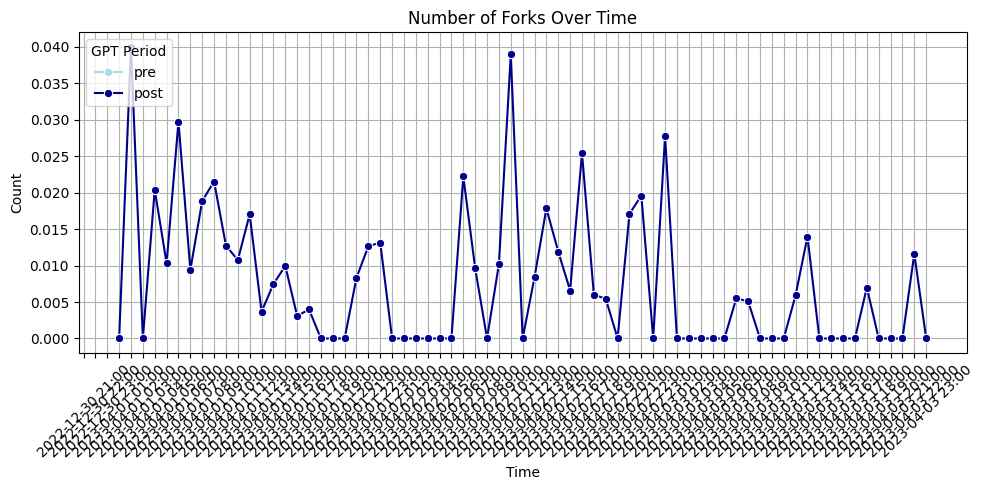

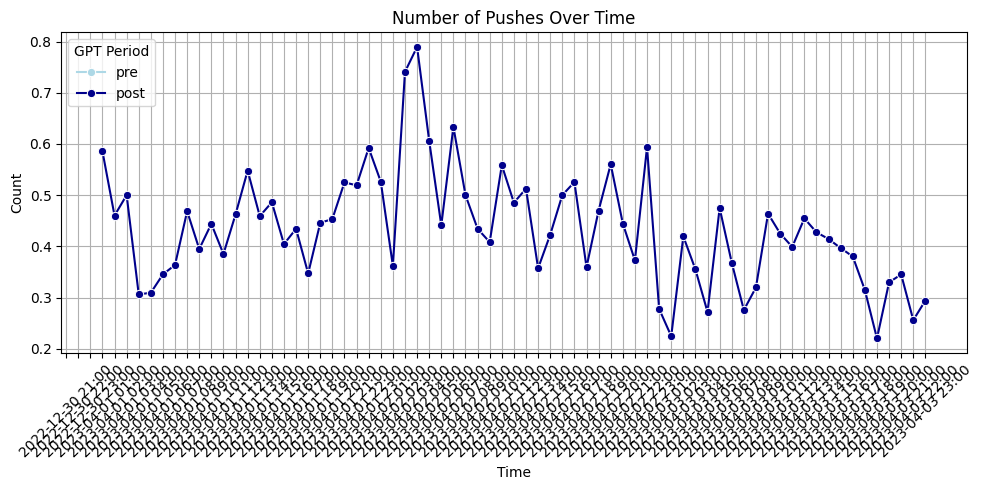

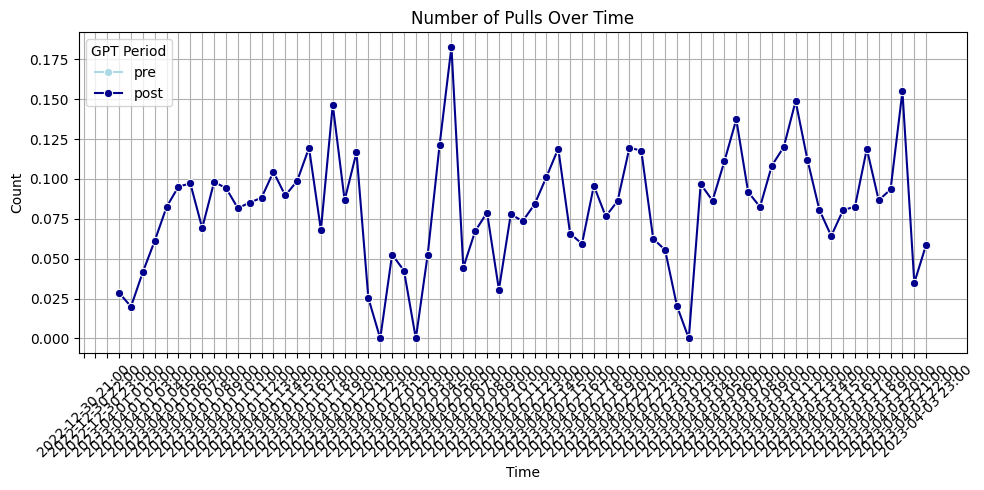

In [8]:
# Group data and calculate means
grouped = panel.groupby(['time_id', 'period']).agg({'is_fork': 'mean', 'is_push': 'mean', 'is_pull': 'mean'}).reset_index()

# Visualization setup
metrics_titles = [('is_fork', 'Number of Forks Over Time'), ('is_push', 'Number of Pushes Over Time'), ('is_pull', 'Number of Pulls Over Time')]
palette = {'pre': 'lightblue', 'post': 'darkblue'}

for metric, title in metrics_titles:
    plt.figure(figsize=(10, 5))
    sns.lineplot(x='time_id', y=metric, hue='period', palette=palette, marker='o', data=grouped, sort=False)
    plt.title(title)
    plt.xlabel('Time')
    plt.ylabel('Count')
    plt.xticks(rotation=45)
    plt.grid(True)
    plt.tight_layout()
    plt.legend(title='GPT Period', loc='upper left')
    plt.show()

# EDA of Panel Data

In [22]:
panel.describe()
panel.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 20690 entries, 0 to 20689
Data columns (total 14 columns):
 #   Column                            Non-Null Count  Dtype  
---  ------                            --------------  -----  
 0   time_id                           20690 non-null  object 
 1   Treatment                         10345 non-null  float64
 2   period                            20690 non-null  object 
 3   Collaboration                     10345 non-null  float64
 4   is_commitcommentevent             10345 non-null  object 
 5   is_forkevent                      10345 non-null  object 
 6   is_issuesevent                    10345 non-null  object 
 7   is_issuecommentevent              10345 non-null  object 
 8   is_pullrequestevent               10345 non-null  object 
 9   is_pullrequestreviewcommentevent  10345 non-null  object 
 10  is_pushevent                      10345 non-null  object 
 11  is_watchevent                     10345 non-null  object 
 12  acto

/tmp/ipykernel_4279/1871509187.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel[col] = panel[col].fillna(0).astype(int)  # fillna replaces NaNs with 0
/tmp/ipykernel_4279/1871509187.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel[col] = panel[col].fillna(0).astype(int)  # fillna replaces NaNs with 0
/tmp/ipykernel_4279/1871509187.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

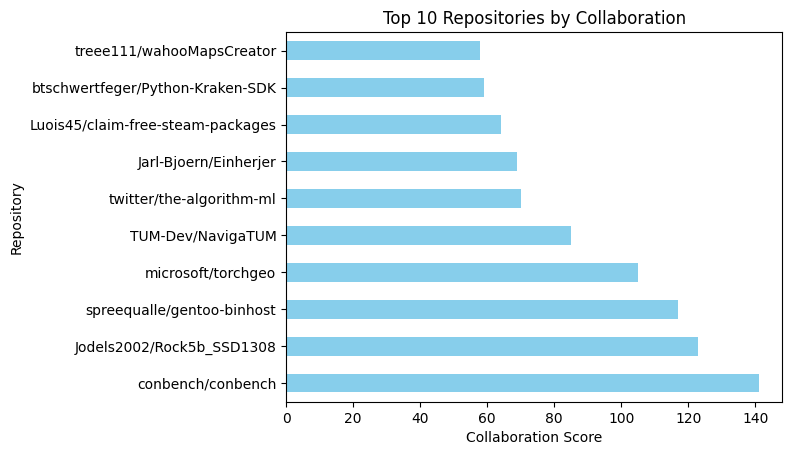

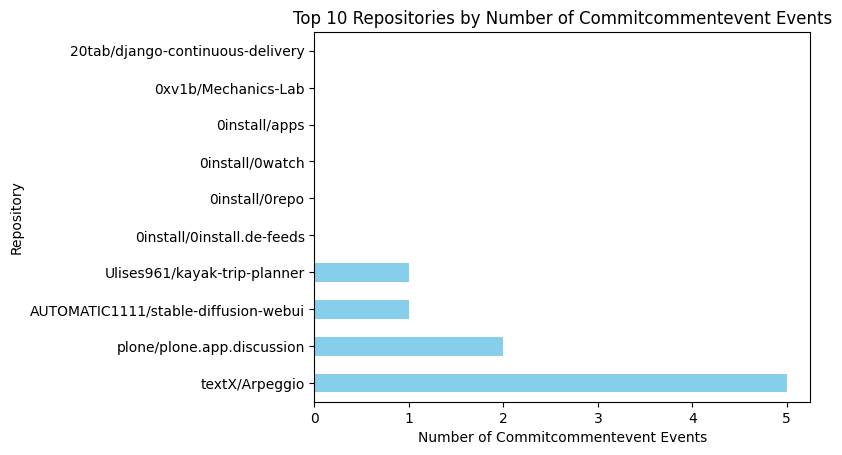

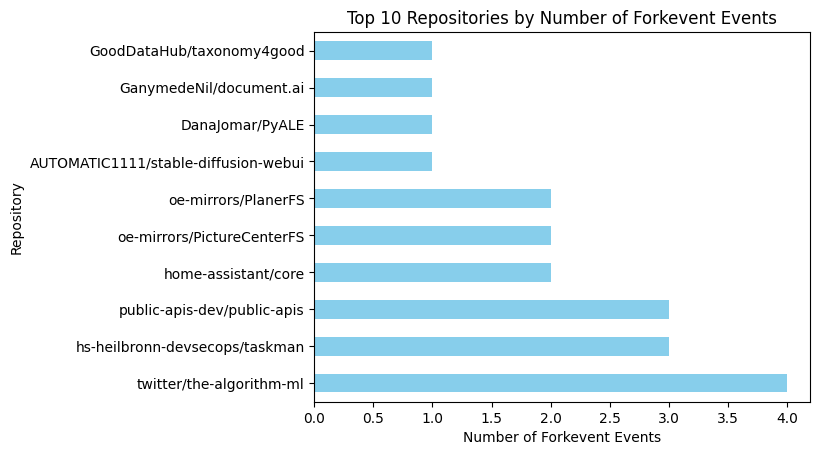

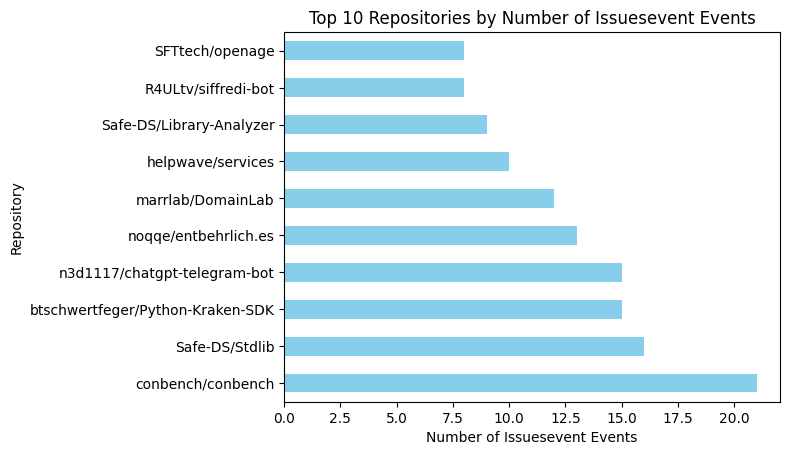

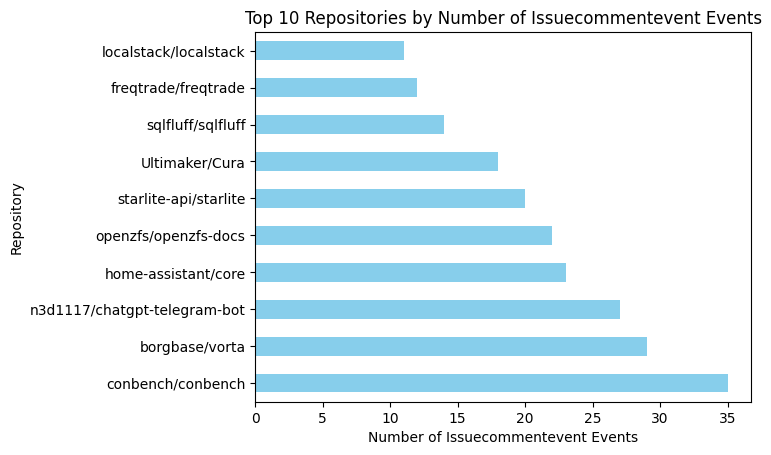

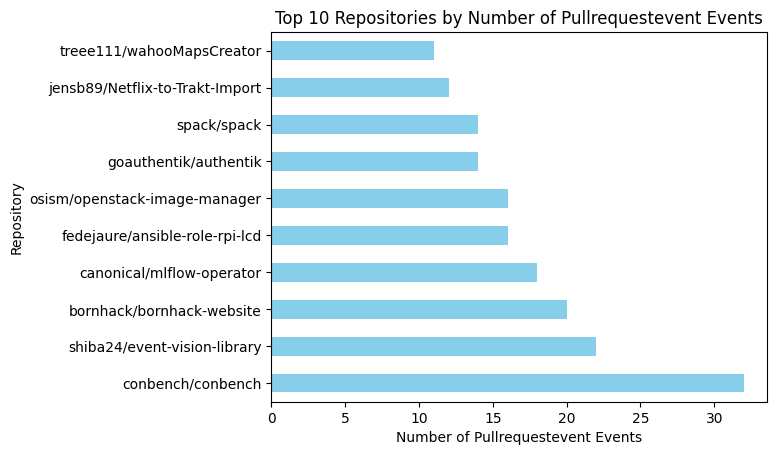

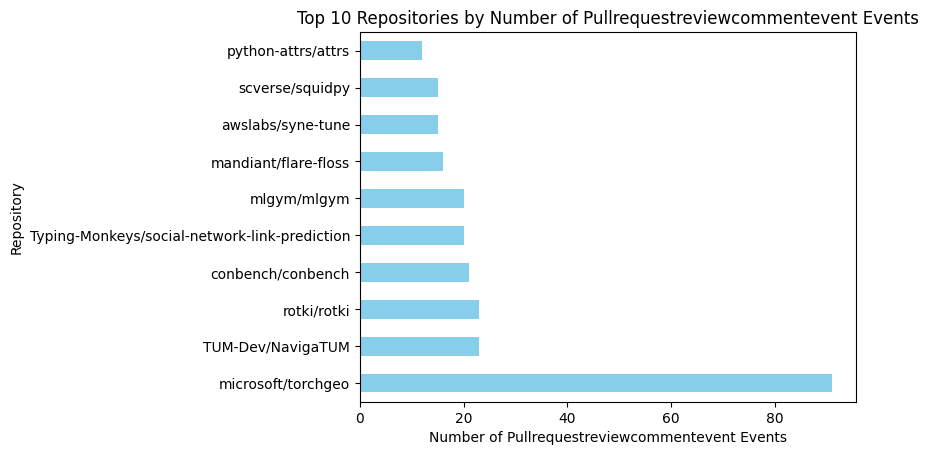

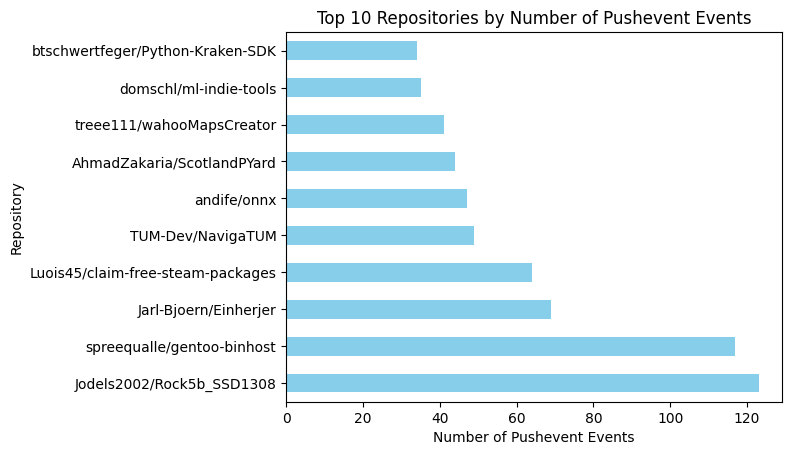

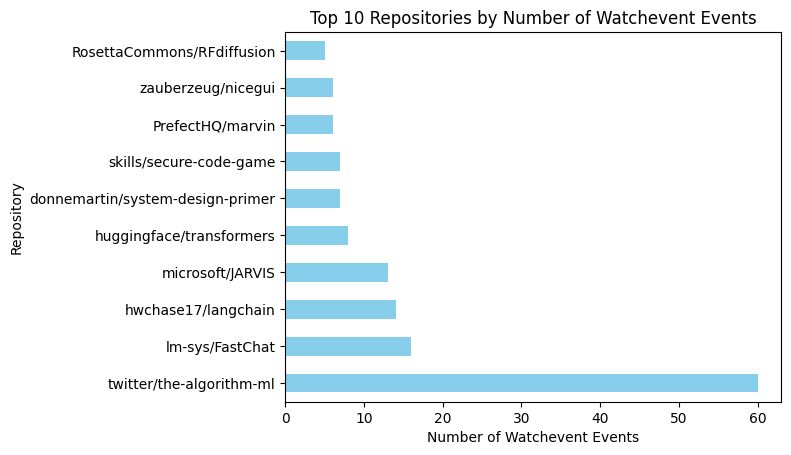

In [25]:
# Replace NaN values with 0 in 'is_' columns before converting to integers
for col in boolean_columns:
    panel[col] = panel[col].fillna(0).astype(int)  # fillna replaces NaNs with 0

# If 'Collaboration' could also have NaN values, handle them similarly
if panel['Collaboration'].dtype != 'int':
    panel['Collaboration'] = panel['Collaboration'].fillna(0).astype(int)

# Continue with your aggregation and plotting as before...

# Aggregate data at the repository level for all these metrics
agg_dict = {col: pd.NamedAgg(column=col, aggfunc='sum') for col in boolean_columns}
agg_dict['Collaboration'] = pd.NamedAgg(column='Collaboration', aggfunc='sum')

repo_level_stats = panel.groupby('repo_name').agg(**agg_dict).reset_index()

# Ensure all relevant 'is_' columns and 'Collaboration' are integers
boolean_columns = [col for col in panel.columns if col.startswith('is_')]
for col in boolean_columns:
    panel[col] = panel[col].astype(int)

# Include 'Collaboration' in the conversion if it's not already an integer
if panel['Collaboration'].dtype != 'int':
    panel['Collaboration'] = panel['Collaboration'].astype(int)

# Aggregate data at the repository level for all these metrics
agg_dict = {col: pd.NamedAgg(column=col, aggfunc='sum') for col in boolean_columns}
agg_dict['Collaboration'] = pd.NamedAgg(column='Collaboration', aggfunc='sum')

repo_level_stats = panel.groupby('repo_name').agg(**agg_dict).reset_index()

# Visualization section for the new metrics
def plot_top_repos(metric, title, xlabel):
    """
    Function to plot top repositories based on a specific metric.
    """
    top_repos = repo_level_stats.nlargest(10, metric)
    top_repos.plot(kind='barh', x='repo_name', y=metric, legend=False, color='skyblue')
    plt.xlabel(xlabel)
    plt.ylabel('Repository')
    plt.title(title)
    plt.show()

# Now, you can call this function for each metric you want to visualize.
plot_top_repos('Collaboration', 'Top 10 Repositories by Collaboration', 'Collaboration Score')

# Similarly, you can do this for other metrics:
for col in boolean_columns:
    metric_name = col.replace('is_', '')
    plot_top_repos(col, f'Top 10 Repositories by Number of {metric_name.capitalize()} Events', f'Number of {metric_name.capitalize()} Events')

# This code creates a function to plot the top repositories based on different metrics,
# allowing you to visualize the top repositories for each type of event or aggregate metric.


/tmp/ipykernel_4279/2075551288.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel[col] = panel[col].fillna(0).astype(int)  # Handling NaNs
/tmp/ipykernel_4279/2075551288.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  panel[col] = panel[col].fillna(0).astype(int)  # Handling NaNs
/tmp/ipykernel_4279/2075551288.py:10: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the document

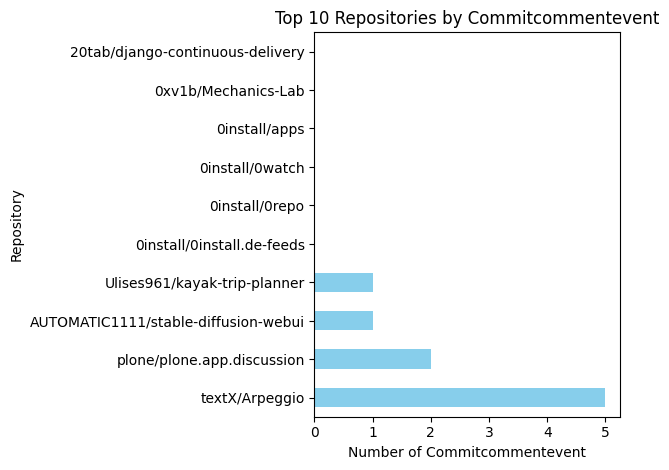

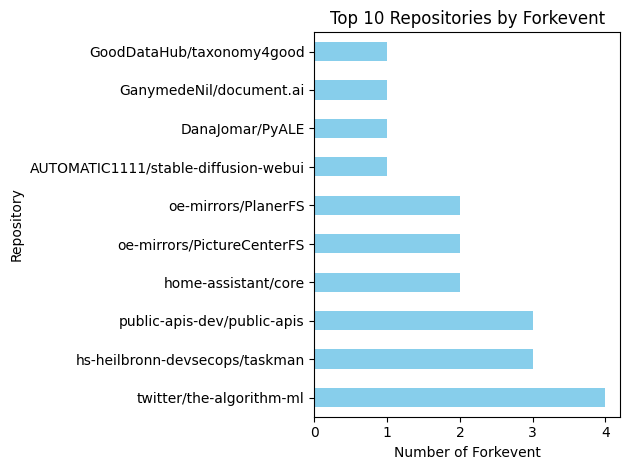

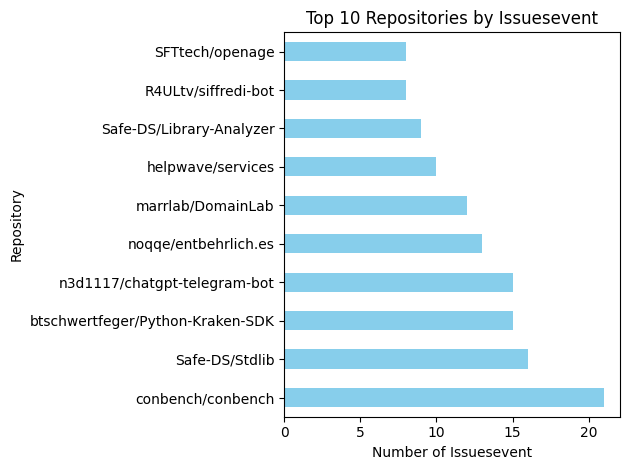

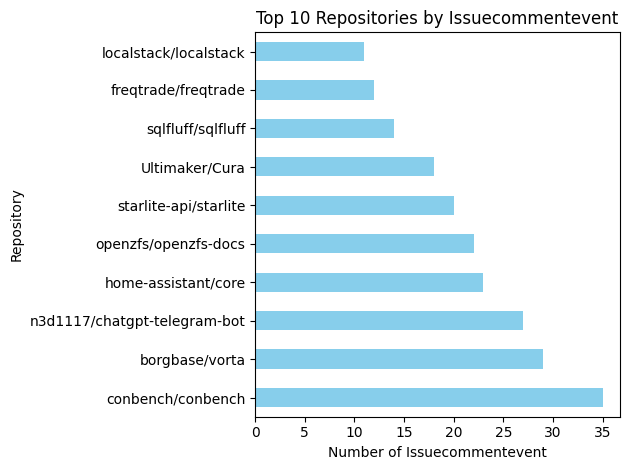

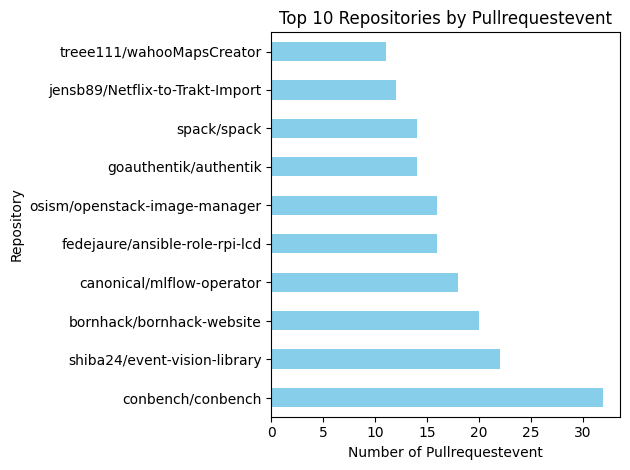

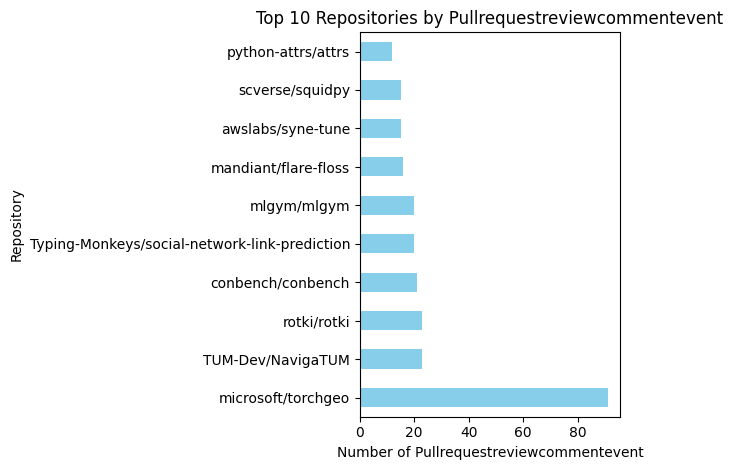

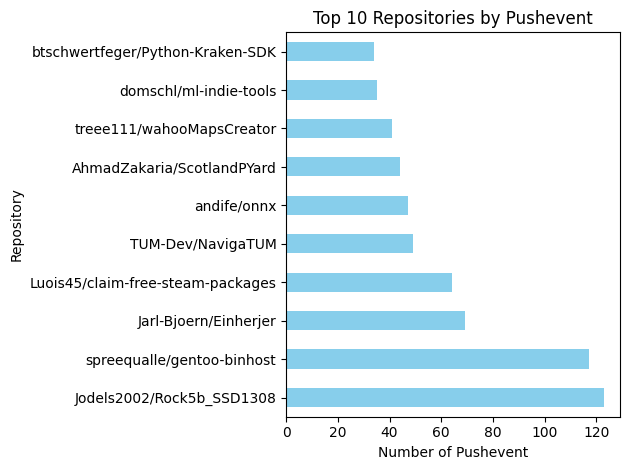

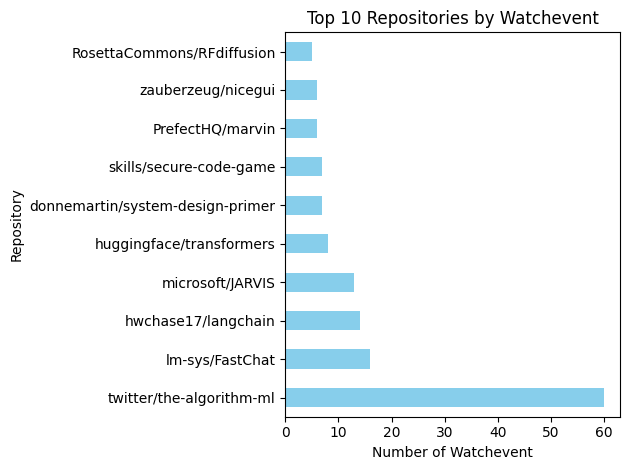

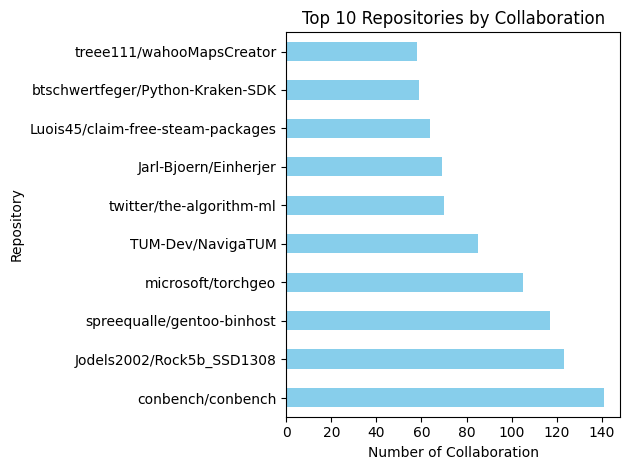

In [26]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'panel' is your DataFrame and it's already properly loaded

# Convert boolean or other types to integers (1 for True, 0 for False)
# and include all new variables for the conversion
boolean_columns = [col for col in panel.columns if col.startswith('is_')]
for col in boolean_columns:
    panel[col] = panel[col].fillna(0).astype(int)  # Handling NaNs

# If 'Collaboration' could also have NaN values, handle them similarly
if 'Collaboration' in panel.columns and panel['Collaboration'].dtype != 'int':
    panel['Collaboration'] = panel['Collaboration'].fillna(0).astype(int)

# Now, we can safely aggregate using 'sum'
# Create a dictionary for the aggregation mapping
agg_dict = {col: pd.NamedAgg(column=col, aggfunc='sum') for col in boolean_columns}
if 'Collaboration' in panel.columns:
    agg_dict['Collaboration'] = pd.NamedAgg(column='Collaboration', aggfunc='sum')

repo_level_stats = panel.groupby('repo_name').agg(**agg_dict).reset_index()

# Function to plot the top N repositories based on a metric
def plot_top_n_repos(df, metric, n=10, xlabel="", title=""):
    top_repos = df.nlargest(n, metric)
    ax = top_repos.plot(kind='barh', x='repo_name', y=metric, legend=False, color='skyblue')
    ax.set_xlabel(xlabel)
    ax.set_ylabel('Repository')
    ax.set_title(title)
    plt.tight_layout()
    plt.show()

# Visualize the top repositories for each metric
for col in repo_level_stats.columns[1:]:  # skip the 'repo_name' column
    metric_name = col.replace('is_', '') if col.startswith('is_') else col
    readable_metric_name = metric_name.capitalize().replace('_', ' ')
    plot_top_n_repos(repo_level_stats, col, n=10, xlabel=f'Number of {readable_metric_name}', title=f'Top 10 Repositories by {readable_metric_name}')


In [10]:
# Convert boolean or other types to integers (1 for True, 0 for False)
panel['is_fork'] = panel['is_fork'].astype(int)
panel['is_push'] = panel['is_push'].astype(int)
panel['is_pull'] = panel['is_pull'].astype(int)

# Now, we can safely aggregate using 'sum'
repo_level_stats = panel.groupby('repo_name').agg(
    num_forks=pd.NamedAgg(column='is_fork', aggfunc='sum'),
    num_pushes=pd.NamedAgg(column='is_push', aggfunc='sum'),
    num_pulls=pd.NamedAgg(column='is_pull', aggfunc='sum')
).reset_index()

# After this conversion and aggregation, the operations should work as expected.
# Now you can proceed with the previous visualization steps.

# For instance, to see the top 10 repos with the most forks:
top_forks = repo_level_stats.nlargest(10, 'num_forks')
top_forks.plot(kind='barh', x='repo_name', y='num_forks', legend=False)
plt.xlabel('Number of Forks')
plt.ylabel('Repository')
plt.title('Top 10 Repositories by Number of Forks')
plt.show()


ValueError: cannot convert float NaN to integer

In [ ]:
# Value counts for number of forks, pushes, and pulls
fork_counts = repo_level_stats['num_forks'].value_counts().sort_index()
push_counts = repo_level_stats['num_pushes'].value_counts().sort_index()
pull_counts = repo_level_stats['num_pulls'].value_counts().sort_index()

# Plotting
plt.figure(figsize=(18, 5))

# Forks
plt.subplot(1, 3, 1)
plt.bar(fork_counts.index, fork_counts.values, color='blue', alpha=0.7)
plt.xlabel('Number of Forks per Repo')
plt.ylabel('Number of Repositories')
plt.title('Distribution of Forks')
plt.grid(True)

# Pushes
plt.subplot(1, 3, 2)
plt.bar(push_counts.index, push_counts.values, color='green', alpha=0.7)
plt.xlabel('Number of Pushes per Repo')
plt.ylabel('Number of Repositories')
plt.title('Distribution of Pushes')
plt.grid(True)

# Pulls
plt.subplot(1, 3, 3)
plt.bar(pull_counts.index, pull_counts.values, color='red', alpha=0.7)
plt.xlabel('Number of Pulls per Repo')
plt.ylabel('Number of Repositories')
plt.title('Distribution of Pulls')
plt.grid(True)

plt.tight_layout()
plt.show()


In [ ]:
import matplotlib.pyplot as plt

# Filtering data based on activity level
activities = ['fork_activity', 'push_activity', 'pull_activity']
activity_labels = ['Fork Activity', 'Push Activity', 'Pull Activity']
colors = ['blue', 'green', 'red']

# Correct mapping from activity to original columns
activity_to_original = {
    'fork_activity': 'num_forks',
    'push_activity': 'num_pushes',
    'pull_activity': 'num_pulls'
}

# Prepare for multiple plots (one for each activity type and level)
fig, axes = plt.subplots(3, 3, figsize=(20, 15))  # 3x3 grid for 3 activity types and 3 levels each

for i, activity in enumerate(activities):
    for level in range(3):  # Levels 0, 1, 2
        # Filter repositories by activity level
        level_data = repo_level_stats[repo_level_stats[activity] == level]
        
        # Correcting the column name used for value counts
        original_column = activity_to_original[activity]
        
        # Value counts for the current activity level
        activity_counts = level_data[original_column].value_counts().sort_index()
        
        # Plotting
        axes[i, level].bar(activity_counts.index, activity_counts.values, color=colors[i], alpha=0.7)
        axes[i, level].set_title(f'{activity_labels[i]}: Level {level}')
        axes[i, level].set_xlabel(f'Number of {activity_labels[i][:-9]}s')  # Removing ' Activity' from label
        axes[i, level].set_ylabel('Number of Repositories')
        axes[i, level].grid(True)

plt.tight_layout()
plt.show()

# Parallel Trends Assumption

In [ ]:
# Statistical Assumptions Check: Parallel Trends
def check_parallel_trends(panel_data, outcome_vars, time_var, treatment_var, period_var):
    """
    Function to plot the trends of outcome variables for treatment and control groups.
    
    Args:
    panel_data (DataFrame): The panel data containing all observations.
    outcome_vars (list): List of outcome variable names to check for parallel trends.
    time_var (str): Name of the time variable in the panel data.
    treatment_var (str): Name of the treatment indicator variable.
    period_var (str): Name of the period indicator variable (0 for pre-treatment, 1 for post-treatment).
    """
    # Ensure data is sorted by time
    panel_data = panel_data.sort_values(by=[time_var])
    
    for outcome in outcome_vars:
        plt.figure(figsize=(15, 7))
        
        # Loop through each level of treatment (0 and 1)
        for treatment in panel_data[treatment_var].unique():
            # Subset the data for the treatment and control groups
            subset = panel_data[panel_data[treatment_var] == treatment]
            
            # Aggregate data by time period
            agg_data = subset.groupby([time_var, period_var]).agg({outcome: 'mean'}).reset_index()
            
            # Plotting
            for period in agg_data[period_var].unique():
                period_data = agg_data[agg_data[period_var] == period]
                label = f"{'Control' if treatment == 0 else 'Treatment'} - {'Pre-Treatment' if period == 0 else 'Post-Treatment'}"
                plt.plot(period_data[time_var], period_data[outcome], marker='o', linestyle='-', label=label)
        
        plt.title(f'Parallel Trends Assumption Check for {outcome}')
        plt.xlabel(time_var)
        plt.ylabel(f'Average {outcome}')
        plt.legend()
        plt.grid(True)
        plt.show()

# Specify the variables
outcome_variables = ['is_fork', 'is_push', 'is_pull']  # add or remove based on your outcome metrics
time_variable = 'time_id'
treatment_variable = 'Treatment'
period_variable = 'period'

# Call the function with your panel data
check_parallel_trends(panel, outcome_variables, time_variable, treatment_variable, period_variable)

### Interpretation - what to look out for when looking at the graphs (once we use the full dataset)
- Pre-Treatment Trends: The lines for Italy and Germany should move in parallel, showing a similar trajectory
- Divergence Post-Treatment: If the treatment had an effect, the two lines might diverge post GPT
- Consistency Across Metrics: If the same trend is consistent across all metrics, there is stronger validation for the assumption

# Calculate DiD Estimates & Fit Regressions

In [ ]:
pd.options.mode.chained_assignment = None  # Disable warnings
# Step 1: Check and convert data types if necessary
print("Current data types:\n", panel[['is_fork', 'is_push', 'is_pull']].dtypes, "\n")

panel['is_fork'] = panel['is_fork'].astype(int)
panel['is_push'] = panel['is_push'].astype(int)
panel['is_pull'] = panel['is_pull'].astype(int)

# Step 2: Check for and handle missing or infinite values
panel = panel.replace([np.inf, -np.inf], np.nan)
panel = panel.dropna(subset=['is_fork', 'is_push', 'is_pull'])

# Step 3: Convert 'period' to numeric if it's categorical
if panel['period'].dtype == object:
    panel['period'] = panel['period'].map({'pre': 0, 'post': 1})

# Step 4: Avoid SettingWithCopyWarning by using .loc for new column creation
panel.loc[:, 'treat_post'] = panel['Treatment'] * panel['period']

# Step 5: Re-run the regression models
outcomes = ['is_fork', 'is_push', 'is_pull']

for outcome in outcomes:
    try:
        model = smf.ols(f'{outcome} ~ Treatment + period + treat_post', data=panel).fit()
        print(f"Results for {outcome}:\n", model.summary(), "\n---\n")
    except Exception as e:
        print(f"An error occurred while processing the model for {outcome}: {str(e)}\n---\n")

pd.options.mode.chained_assignment = 'warn'  # reset to the default warning behavior

# Interpretation of DiD Estimates and significance levels
The DiD analysis indicates that the treatment had no statistically significant impact on the 'is_fork', 'is_push', and 'is_pull' metrics, suggesting that the observed changes in these behaviors cannot be attributed to the intervention under study (for this preliminary sample)

# (Outdated EDA)

## Calculate different metrics to measure collaboration on repository-level and store in new df 'repos'

In [ ]:
# Extracting repository name and id for easy grouping
commits['repo_name'] = commits['repo'].apply(lambda x: x['name'])
commits['repo_id'] = commits['repo'].apply(lambda x: x['id'])
commits['actor_login'] = commits['actor'].apply(lambda x: x['login'])

# Calculating metrics
grouped = commits.groupby(['repo_name', 'repo_id'])

forks_per_repo = grouped.apply(lambda x: (x['type'] == 'ForkEvent').sum())
push_per_repo = grouped.apply(lambda x: (x['type'] == 'PushEvent').sum())
pull_per_repo = grouped.apply(lambda x: (x['type'] == 'PullRequestEvent').sum())
unique_contributors_per_repo = grouped['actor_login'].nunique()
total_contributors_per_repo = grouped['actor_login'].size()

# Combining metrics into a new dataframe
repos = pd.DataFrame({
    'Forks': forks_per_repo,
    'Pushes': push_per_repo,
    'Pulls': pull_per_repo,
    'UniqueContributors': unique_contributors_per_repo,
    'TotalContributions': total_contributors_per_repo,
}).reset_index()
repos.head()

In [ ]:
repos.describe()

### Visualisations

In [ ]:
sns.set_theme(style="whitegrid")
metrics = ['Forks', 'Pushes', 'Pulls', 'UniqueContributors', 'TotalContributions']
for metric in metrics:
    plt.figure(figsize=(12, 6))
    value_counts = repos[metric].value_counts().sort_index()
    plt.scatter(value_counts.index, value_counts.values, alpha=0.5, color='navy')
    plt.title(f'Repositories Distribution by Number of {metric}', fontsize=20)
    plt.xlabel(f'Number of {metric} (in a Repository)', fontsize=20)
    plt.ylabel(f'Number of Repositories', fontsize=20)
    plt.grid(True)
    plt.tight_layout()
    plt.show()